# PREDICTIVE ANALYTICS 

### DEMAND FORECASTING DEMO


#### Ife Anjorin

<b>Importing all required Libraries</b>

In [ ]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

from pylab import rcParams

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import pandas_profiling


import statsmodels.api as sm
import matplotlib
matplotlib.style.use('ggplot') # optional: for ggplot-like style

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

<b> Import Sales data </b>

In [4]:
df = pd.read_excel("Sample - Superstore.xls")

In [7]:
df.head() # to see an overview of the data attributes(columns) over 5 instances(rows)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


### <b>DATA EXPLORATION AND PREPROCESSING</b>

In [10]:
df.profile_report() # Profile report module is used to obtain quick data summary and Exploration in a compact view

<b>The sales data has several categories but for this demo, the focus will be to run Demand forecasting on the Technology category</b>

In [22]:
Technology = df.loc[df['Category'] == 'Technology']
Technology.head()

,Row_ID,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Customer_Name,Segment,Country,City,State,Postal_Code,Region,Product_ID,Category,Sub-Category,Product_Name,Sales,Quantity,Discount,Profit
7,8,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,TEC-PH-10002275,Technology,Phones,Mitel 5320 IP Phone VoIP phone,907.152,6,0.2,90.7152
11,12,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,TEC-PH-10002033,Technology,Phones,Konftel 250 Conference phone - Charcoal black,911.424,4,0.2,68.3568
19,20,CA-2014-143336,2014-08-27,2014-09-01,Second Class,ZD-21925,Zuschuss Donatelli,Consumer,United States,San Francisco,California,94109,West,TEC-PH-10001949,Technology,Phones,Cisco SPA 501G IP Phone,213.480,3,0.2,16.0110
26,27,CA-2016-121755,2016-01-16,2016-01-20,Second Class,EH-13945,Eric Hoffmann,Consumer,United States,Los Angeles,California,90049,West,TEC-AC-10003027,Technology,Accessories,Imation 8GB Mini TravelDrive USB 2.0 Flash Drive,90.570,3,0.0,11.7741
35,36,CA-2016-117590,2016-12-08,2016-12-10,First Class,GH-14485,Gene Hale,Corporate,United States,Richardson,Texas,75080,Central,TEC-PH-10004977,Technology,Phones,GE 30524EE4,1097.544,7,0.2,123.4737


In [20]:
print ("Mim Date is", Technology['Order_Date'].min())
print ("Max Date is ", Technology['Order_Date'].max())

Mim Date is 2014-01-06 00:00:00
Max Date is  2017-12-30 00:00:00


Next, we remove columns we do not need, check missing values and aggregate sales by date

In [24]:
cols = ['Row_ID', 'Order_ID', 'Ship_Date', 'Ship_Mode', 'Customer_ID', 'Customer_Name', 'Segment', 'Country', 'City', 'State', 'Postal_Code', 'Region', 'Product_ID', 'Category', 'Sub-Category', 'Product_Name', 'Quantity', 'Discount', 'Profit']
Technology.drop(cols, axis=1, inplace=True)
Technology = Technology.sort_values('Order_Date')
Technology.isnull().sum()

Order_Date    0
Sales         0
dtype: int64

In [25]:
Technology.head()

,Order_Date,Sales
7478,2014-01-06,755.96
7477,2014-01-06,391.98
593,2014-01-09,31.20
765,2014-01-13,646.74
1913,2014-01-15,149.95


In [26]:
Technology = Technology.groupby('Order_Date')['Sales'].sum().reset_index()
Technology.head()

,Order_Date,Sales
0,2014-01-06,1147.94
1,2014-01-09,31.20
2,2014-01-13,646.74
3,2014-01-15,149.95
4,2014-01-16,124.20


In [27]:
Technology = Technology.set_index('Order_Date')
Technology.head()

,Sales
Order_Date,
2014-01-06,1147.94
2014-01-09,31.20
2014-01-13,646.74
2014-01-15,149.95
2014-01-16,124.20


Next, the aggregated data is index as Time Series Data

In [29]:
Timeindexlist = Technology.index.to_list()

In [31]:
Timeindexlist[:10]

[Timestamp('2014-01-06 00:00:00'),
 Timestamp('2014-01-09 00:00:00'),
 Timestamp('2014-01-13 00:00:00'),
 Timestamp('2014-01-15 00:00:00'),
 Timestamp('2014-01-16 00:00:00'),
 Timestamp('2014-01-20 00:00:00'),
 Timestamp('2014-01-26 00:00:00'),
 Timestamp('2014-02-01 00:00:00'),
 Timestamp('2014-02-02 00:00:00'),
 Timestamp('2014-02-06 00:00:00')]

The current datetime data can be tricky to work with, therefore, we will use the   
averages daily sales value for that month instead, and use the start of each month as the timestamp.

In [32]:
y = Technology['Sales'].resample('MS').mean()

In [35]:
y['2017':]

Order_Date
2017-01-01    1195.218071
2017-02-01     430.501714
2017-03-01    1392.859250
2017-04-01     825.559133
2017-05-01     678.329400
2017-06-01     853.055000
2017-07-01    1054.996636
2017-08-01     978.842333
2017-09-01    1077.704120
2017-10-01    1493.439227
2017-11-01    1996.750920
2017-12-01     955.865652
Freq: MS, Name: Sales, dtype: float64

### <b>VISUALIZING THE SALES DATA FOR TECHNOLOGY TIME SERIES</b>

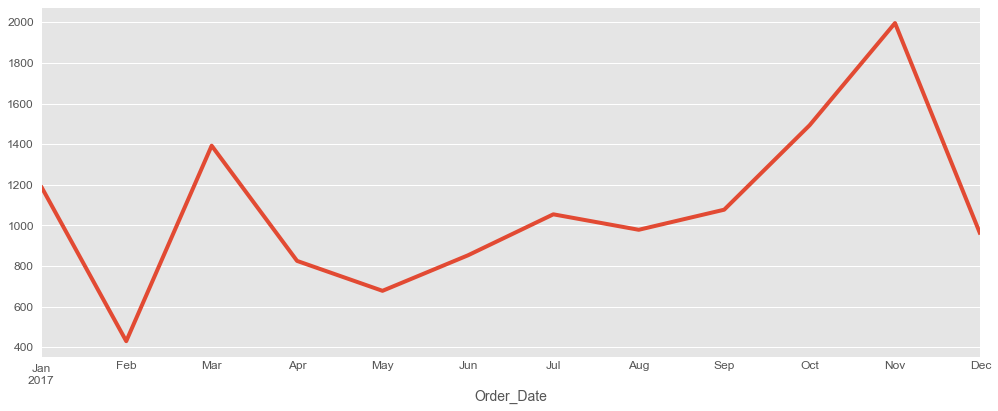

In [41]:
# Here we plot Technology Time Series Data for the Year 2017
y['2017':].plot(figsize=(15, 6))
plt.show()

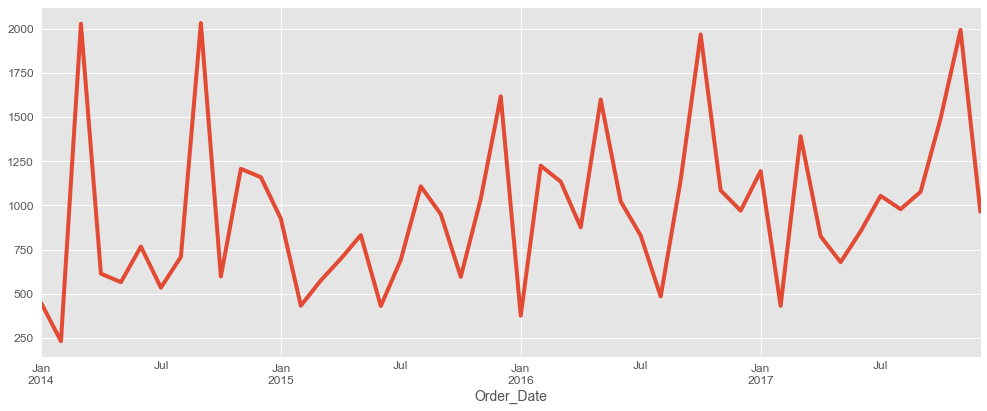

In [42]:
# This plots the entire Technology sales data for all existing time in the time series
y.plot(figsize=(15, 6))
plt.show()

Some distinguishable patterns appear in the Time series plot.    
The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high towards the end of the year.   
There is always an upward trend within any single year with a couple of low months in the mid of the year.     

#### Decomposing the Time Series Data

Decomposing the  time-series into three distinct components: Trend, Seasonality, and Noise.

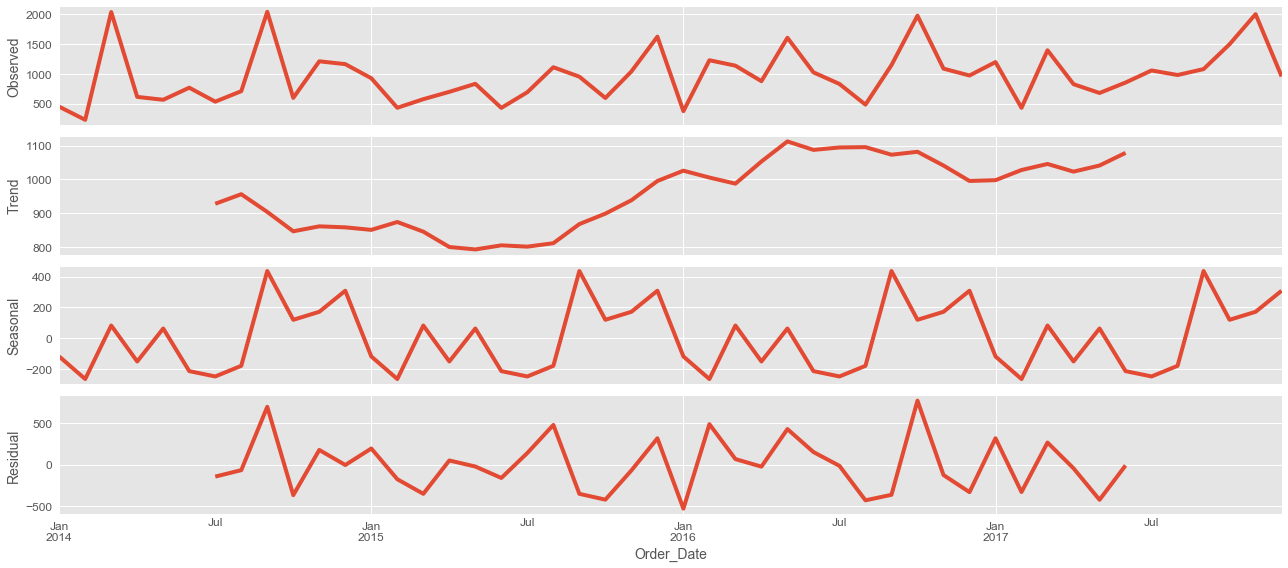

In [44]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the sales of Technology is unstable, along with its obvious seasonality

### <b>BUILDING THE DEMAND FORECASTING MODEL USING TIME SERIES ARIMA MODEL</b>  

ARIMA stands for Autoregressive Integrated Moving Average.
ARIMA models are denoted with the notation ARIMA(p, d, q).   
These three parameters account for seasonality, trend, and noise in data: 

In [64]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Possible parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Possible parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


Next is parameter Selection for the ARIMA Time Series Model.   
The  goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.  
This is  an aspect of multivariable optimization  

In [51]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:791.4891765009955
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1419.3953221106285
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:549.0156237882128
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:564.1031529698099
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:542.9210079120221
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:372.6612068172691
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:750.8969484750886
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3236.4001541551806
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:535.0489454746596
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:566.0827904028098
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:526.532259580665
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:373.8760065868645
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:729.3478530237927
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1474.2991109581867
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:562.7585881087532
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:543.3082156228088
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1661.6786620295043
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:377.03544814349596
ARIMA(

The above output that ARIMA(1, 1, 1)x(1, 1, 0, 12) yields the lowest   
AIC value of 343.603. Therefore we should consider this to be optimal option.

### <b>MODEL EVALUATION</b>  

In [52]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2660      0.249     -1.067      0.286      -0.755       0.223
ma.L1         -1.0001      0.348     -2.870      0.004      -1.683      -0.317
ar.S.L12      -0.5003      0.175     -2.852      0.004      -0.844      -0.157
sigma2      2.243e+05   1.55e-06   1.44e+11      0.000    2.24e+05    2.24e+05


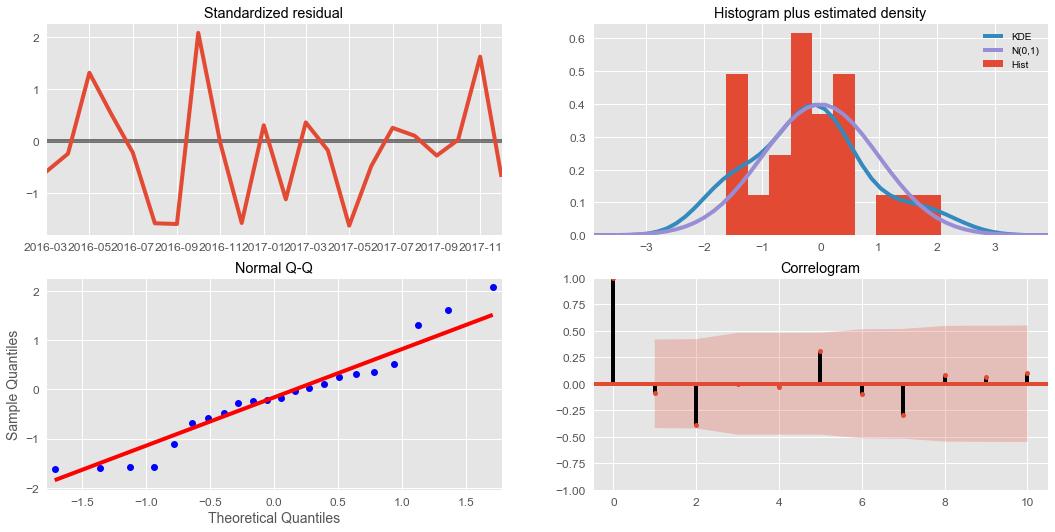

In [53]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

The model is not perfect, however, our model diagnostics suggests that the model residuals are near normally distributed.


### <b>DEMAND FORECAST VALIDATION</b> 

To understand the accuracy of our forecasts, 
real sales of the time series is  compared with  
predicted sales where forecasts  is set  
to start at 2017–01–01 to the end of the data.

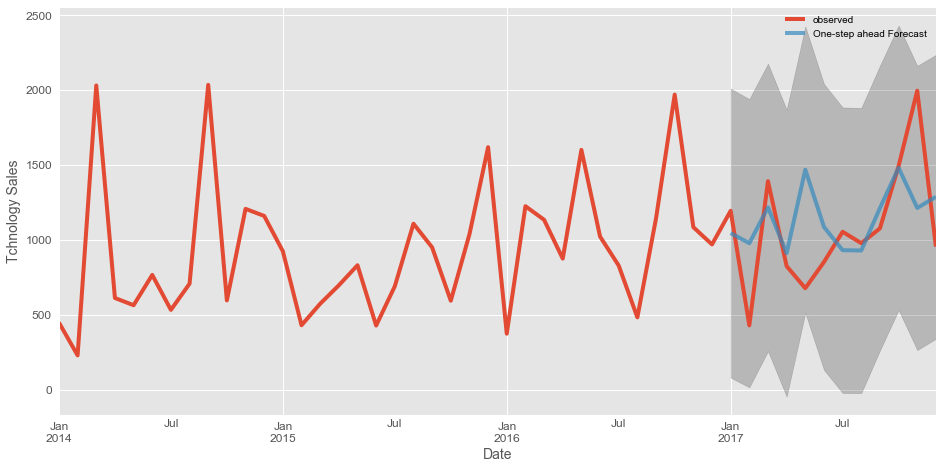

In [58]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Tchnology Sales')
plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. 
Overall, the  forecasts align fairly well with the true values, showing an upward trend   
starts from the beginning of the year and captured the seasonality toward the end of the year.

In [68]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 150095.64


In [69]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 387.42


### <b>PRODUCING THE VISUALIZED FORECAST</b>  

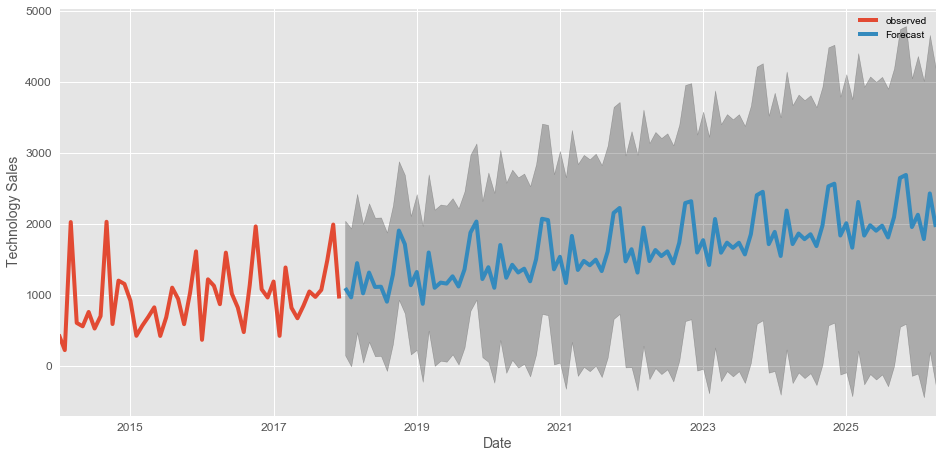

In [57]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Technology Sales')
plt.legend()
plt.show()

The model clearly captured Technology sales seasonality.   
As it forecast further out into the future, it is natural for us to become less confident in our values.  
This is reflected by the confidence intervals generated by the model, which grow larger as it moves further out into the future.  

## MULTI-VARIABLE OPTIMIZATION

An Optimization Problem is the problem of finding those points in
a domain where a function reaches its largest and its smallest
values (referred to as maximum and minimum points):

In most static optimization problems there is
an objective function f(x) = f(x1, x2, ..., xn), a real-valued
function of n variables whose value is to be optimized, i.e.
maximized or minimized.
an admissible set (or feasible set) S that is some subset of R
n